In [ ]:

# Install required packages
!pip install -q kagglehub

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory for saving model checkpoints
import os
save_dir = '/content/drive/MyDrive/face_sketch_cyclegan'
os.makedirs(save_dir, exist_ok=True)

# Download the dataset
import kagglehub
path = kagglehub.dataset_download("almightyj/person-face-sketches")
print("Path to dataset files:", path)

# Import necessary libraries
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the dataset class
class FaceSketchDataset(Dataset):
    def __init__(self, root_dir, domain, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            domain (string): 'photos' or 'sketches'
            split (string): 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = os.path.join(root_dir, split, domain)
        self.transform = transform
        self.image_paths = [os.path.join(self.root_dir, img) for img in sorted(os.listdir(self.root_dir))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataloaders
def get_dataloaders(root_dir, batch_size=1, split='train'):
    photos_dataset = FaceSketchDataset(root_dir, 'photos', split, transform)
    sketches_dataset = FaceSketchDataset(root_dir, 'sketches', split, transform)

    photos_loader = DataLoader(photos_dataset, batch_size=batch_size, shuffle=(split=='train'), num_workers=2)
    sketches_loader = DataLoader(sketches_dataset, batch_size=batch_size, shuffle=(split=='train'), num_workers=2)

    return photos_loader, sketches_loader

# Define model components
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride=2, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Replay buffer for training stability
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.detach():
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

# Learning rate scheduler
class LambdaLR():
    def __init__(self, n_epochs, decay_start_epoch):
        assert (n_epochs > decay_start_epoch)
        self.n_epochs = n_epochs
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

# Function to generate sample images during training
def sample_images(root_dir, epoch, G_AB, G_BA, device):
    """Saves a generated sample from the test set"""
    G_AB.eval()
    G_BA.eval()

    # Load test data
    photos_loader, sketches_loader = get_dataloaders(root_dir, batch_size=5, split='test')

    # Get samples
    real_A = next(iter(photos_loader)).to(device)
    real_B = next(iter(sketches_loader)).to(device)

    # Generate output
    with torch.no_grad():
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # Reconstruct images
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)

        # Concatenate images
        image_grid = torch.cat((
            real_A, fake_B, recov_A, real_B, fake_A, recov_B
        ), 0)

        # Denormalize
        image_grid = (image_grid + 1) / 2

        # Save image grid
        save_image(image_grid, f"{save_dir}/sample_{epoch}.png", nrow=5, normalize=False)

# Main training function
def train_cyclegan(root_dir, epochs=10, batch_size=1, lr=0.0002, b1=0.5, b2=0.999,
                  decay_epoch=5, checkpoint_interval=1):
    # Initialize models
    G_AB = Generator(n_residual_blocks=6).to(device)  # Photo to Sketch (using fewer residual blocks to save memory)
    G_BA = Generator(n_residual_blocks=6).to(device)  # Sketch to Photo
    D_A = Discriminator().to(device)  # Discriminator for Photos
    D_B = Discriminator().to(device)  # Discriminator for Sketches

    # Initialize optimizers
    optimizer_G = torch.optim.Adam(
        list(G_AB.parameters()) + list(G_BA.parameters()),
        lr=lr, betas=(b1, b2)
    )
    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

    # Initialize learning rate schedulers
    lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
        optimizer_G, lr_lambda=LambdaLR(epochs, decay_epoch).step
    )
    lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_A, lr_lambda=LambdaLR(epochs, decay_epoch).step
    )
    lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_B, lr_lambda=LambdaLR(epochs, decay_epoch).step
    )

    # Loss functions
    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    # Create dataloaders
    photos_loader, sketches_loader = get_dataloaders(root_dir, batch_size, 'train')

    # Buffers for update discriminator
    fake_A_buffer = ReplayBuffer()
    fake_B_buffer = ReplayBuffer()

    # Training loop - 10 epochs
    for epoch in range(epochs):
        start_time = time.time()

        # Track losses for reporting
        epoch_loss_G = 0
        epoch_loss_D_A = 0
        epoch_loss_D_B = 0

        for i, (real_A, real_B) in enumerate(zip(photos_loader, sketches_loader)):
            # Check if we have enough data (both loaders might have different lengths)
            if i >= min(len(photos_loader), len(sketches_loader)):
                break

            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # Adversarial ground truths
            valid = torch.ones((real_A.size(0), 1, 30, 30), requires_grad=False).to(device)
            fake = torch.zeros((real_A.size(0), 1, 30, 30), requires_grad=False).to(device)

            # ------------------
            #  Train Generators
            # ------------------

            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)

            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)

            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            lambda_id = 0.5
            lambda_cycle = 10.0

            loss_G = loss_GAN + lambda_cycle * loss_cycle + lambda_id * loss_identity

            loss_G.backward()
            optimizer_G.step()

            # Update running loss
            epoch_loss_G += loss_G.item()

            # -----------------------
            #  Train Discriminator A
            # -----------------------

            optimizer_D_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_A(real_A), valid)
            # Fake loss (using buffer)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # Update running loss
            epoch_loss_D_A += loss_D_A.item()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_B(real_B), valid)
            # Fake loss (using buffer)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            # Update running loss
            epoch_loss_D_B += loss_D_B.item()

            # Print progress every 50 batches
            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{min(len(photos_loader), len(sketches_loader))}] "
                      f"[D_A loss: {loss_D_A.item():.4f}] [D_B loss: {loss_D_B.item():.4f}] "
                      f"[G loss: {loss_G.item():.4f}, adv: {loss_GAN.item():.4f}, cycle: {loss_cycle.item():.4f}, id: {loss_identity.item():.4f}]")

        # Calculate average epoch losses
        avg_loss_G = epoch_loss_G / min(len(photos_loader), len(sketches_loader))
        avg_loss_D_A = epoch_loss_D_A / min(len(photos_loader), len(sketches_loader))
        avg_loss_D_B = epoch_loss_D_B / min(len(photos_loader), len(sketches_loader))

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        # Save models after each epoch
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save(G_AB.state_dict(), f"{save_dir}/G_AB_{epoch}.pth")
            torch.save(G_BA.state_dict(), f"{save_dir}/G_BA_{epoch}.pth")
            torch.save(D_A.state_dict(), f"{save_dir}/D_A_{epoch}.pth")
            torch.save(D_B.state_dict(), f"{save_dir}/D_B_{epoch}.pth")

        # Report epoch stats
        elapsed_time = time.time() - start_time
        print(f'Epoch {epoch} completed in {elapsed_time:.2f} seconds')
        print(f'Avg losses - Generator: {avg_loss_G:.4f}, D_A: {avg_loss_D_A:.4f}, D_B: {avg_loss_D_B:.4f}')

        # Generate sample images after each epoch
        sample_images(root_dir, epoch, G_AB, G_BA, device)

    return G_AB, G_BA, D_A, D_B

# Test function to evaluate the trained model
def test_model(G_AB, G_BA, root_dir, batch_size=4):
    """Test the trained model"""
    G_AB.to(device).eval()
    G_BA.to(device).eval()

    # Create test dataloaders
    photos_loader, sketches_loader = get_dataloaders(root_dir, batch_size, 'test')

    # Create directories for results
    os.makedirs(f"{save_dir}/test_results/photo_to_sketch", exist_ok=True)
    os.makedirs(f"{save_dir}/test_results/sketch_to_photo", exist_ok=True)

    # Test photo to sketch
    print("Generating sketches from photos...")
    with torch.no_grad():
        for i, real_A in enumerate(tqdm(photos_loader)):
            real_A = real_A.to(device)
            fake_B = G_AB(real_A)

            # Denormalize
            fake_B = (fake_B + 1) / 2

            # Save images
            for j, img in enumerate(fake_B):
                save_image(img, f"{save_dir}/test_results/photo_to_sketch/img_{i*batch_size+j}.png")

    # Test sketch to photo
    print("Generating photos from sketches...")
    with torch.no_grad():
        for i, real_B in enumerate(tqdm(sketches_loader)):
            real_B = real_B.to(device)
            fake_A = G_BA(real_B)

            # Denormalize
            fake_A = (fake_A + 1) / 2

            # Save images
            for j, img in enumerate(fake_A):
                save_image(img, f"{save_dir}/test_results/sketch_to_photo/img_{i*batch_size+j}.png")

    print("Testing completed! Results saved to Google Drive.")

# Main execution
def main():
    # Use the path from dataset download
    root_dir = path

    # Print dataset info
    photos_loader, sketches_loader = get_dataloaders(root_dir, batch_size=1, split='train')
    print(f"Training dataset - Photos: {len(photos_loader)} images, Sketches: {len(sketches_loader)} images")

    # Train for 10 epochs
    print("Starting training for 10 epochs...")
    G_AB, G_BA, D_A, D_B = train_cyclegan(
        root_dir,
        epochs=5,            # As requested, only 10 epochs
        batch_size=4,         # Keep batch size small for stability
        lr=0.0002,
        b1=0.5,
        b2=0.999,
        decay_epoch=1,        # Start decaying learning rate halfway
        checkpoint_interval=1  # Save after each epoch
    )

    # Test the trained model
    print("Training complete. Starting testing...")
    test_model(G_AB, G_BA, root_dir, batch_size=4)

    print("Complete! Model checkpoints and results are saved to your Google Drive.")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /kaggle/input/person-face-sketches
Using device: cuda
Training dataset - Photos: 20655 images, Sketches: 20655 images
Starting training for 10 epochs...
[Epoch 0/5] [Batch 0/5164] [D_A loss: 0.4879] [D_B loss: 0.4601] [G loss: 7.7448, adv: 0.7409, cycle: 0.6664, id: 0.6799]
[Epoch 0/5] [Batch 50/5164] [D_A loss: 0.3541] [D_B loss: 0.0928] [G loss: 2.3929, adv: 0.5645, cycle: 0.1736, id: 0.1847]
[Epoch 0/5] [Batch 100/5164] [D_A loss: 0.2012] [D_B loss: 0.1099] [G loss: 1.8416, adv: 0.4106, cycle: 0.1363, id: 0.1361]
[Epoch 0/5] [Batch 150/5164] [D_A loss: 0.2561] [D_B loss: 0.2640] [G loss: 1.8694, adv: 0.3518, cycle: 0.1440, id: 0.1560]
[Epoch 0/5] [Batch 200/5164] [D_A loss: 0.2181] [D_B loss: 0.1463] [G loss: 1.6613, adv: 0.3816, cycle: 0.1202, id: 0.1558]
[Epoch 0/5] [Batch 250/5164] [D_A loss: 0.2291] [D_B loss: 0.1459] [G loss: 1.

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Trying to load models from current directory...
Models loaded successfully!

🎨 Face ↔ Sketch Converter
Upload an image and choose the conversion direction.
Enter conversion type (1 for Photo to Sketch, 2 for Sketch to Photo): 1
Selected: Photo to Sketch
Now upload your image...


Saving 4.jpg to 4.jpg


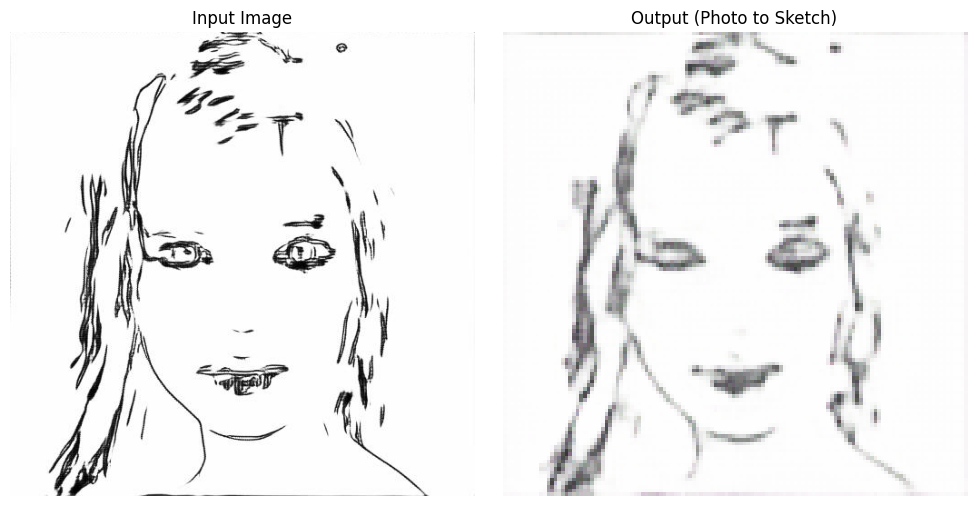

Output saved as output_4.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Face-Sketch Converter for Google Colab
# This version includes handling for model loading issues

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
import io
import os

# Mount Google Drive to access model files
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define the ResNetBlock class
class ResNetBlock(torch.nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.ReflectionPad2d(1),
            torch.nn.Conv2d(dim, dim, kernel_size=3),
            torch.nn.InstanceNorm2d(dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.ReflectionPad2d(1),
            torch.nn.Conv2d(dim, dim, kernel_size=3),
            torch.nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# Define the ResNetGenerator class
class ResNetGenerator(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=6):
        super(ResNetGenerator, self).__init__()
        model = [
            torch.nn.ReflectionPad2d(3),
            torch.nn.Conv2d(in_channels, 64, kernel_size=7),
            torch.nn.InstanceNorm2d(64),
            torch.nn.ReLU(inplace=True)
        ]

        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                torch.nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                torch.nn.InstanceNorm2d(out_features),
                torch.nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        for _ in range(n_blocks):
            model += [ResNetBlock(in_features)]

        out_features = in_features // 2
        for _ in range(2):
            model += [
                torch.nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                torch.nn.InstanceNorm2d(out_features),
                torch.nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [torch.nn.ReflectionPad2d(3)]
        model += [torch.nn.Conv2d(64, out_channels, kernel_size=7)]
        model += [torch.nn.Tanh()]

        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize generator models
G_AB = ResNetGenerator().to(device)  # Photo to Sketch
G_BA = ResNetGenerator().to(device)  # Sketch to Photo

# Function to upload models
def upload_models():
    print("Please upload your model files (G_AB_epoch4.pth and G_BA_epoch4.pth)...")
    uploaded_models = files.upload()

    model_paths = {}
    for filename in uploaded_models.keys():
        with open(filename, 'wb') as f:
            f.write(uploaded_models[filename])
        model_paths[filename] = filename
        print(f"Saved {filename}")

    return model_paths

# Try loading models, if fail, ask user to upload
try:
    # First try loading models directly
    print("Trying to load models from current directory...")
    G_AB.load_state_dict(torch.load("G_AB_epoch4.pth", map_location=device))
    G_BA.load_state_dict(torch.load("G_BA_epoch4.pth", map_location=device))
    print("Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")

    # Try to find models in various locations
    potential_paths = [
        "./*.pth",
        "./drive/MyDrive/*.pth",
        "/content/*.pth",
        "/content/drive/MyDrive/*.pth"
    ]

    import glob
    found_models = False

    for path_pattern in potential_paths:
        model_files = glob.glob(path_pattern)
        if model_files:
            print(f"Found model files in {path_pattern}: {model_files}")
            try:
                for model_file in model_files:
                    if "G_AB" in model_file:
                        G_AB.load_state_dict(torch.load(model_file, map_location=device))
                        print(f"Loaded {model_file}")
                    elif "G_BA" in model_file:
                        G_BA.load_state_dict(torch.load(model_file, map_location=device))
                        print(f"Loaded {model_file}")

                if hasattr(G_AB, 'model') and hasattr(G_BA, 'model'):
                    found_models = True
                    break
            except Exception as e:
                print(f"Error loading models from {path_pattern}: {e}")

    if not found_models:
        print("Could not find valid model files. Please upload them now.")
        model_paths = upload_models()

        try:
            if "G_AB_epoch4.pth" in model_paths:
                G_AB.load_state_dict(torch.load(model_paths["G_AB_epoch4.pth"], map_location=device))
            if "G_BA_epoch4.pth" in model_paths:
                G_BA.load_state_dict(torch.load(model_paths["G_BA_epoch4.pth"], map_location=device))
        except Exception as e:
            print(f"Error loading uploaded models: {e}")
            print("The model files may be corrupted or in an incorrect format.")
            print("Please check that you have the correct model files and try again.")
            raise

G_AB.eval()
G_BA.eval()

# Transform for input image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to de-normalize tensor to image
def denorm(tensor):
    img = tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    return img

def process_image(img, conversion_type):
    # Prepare the image
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Process the image
    with torch.no_grad():
        if conversion_type == "Photo to Sketch":
            output_tensor = G_AB(input_tensor)
        else:
            output_tensor = G_BA(input_tensor)

    # Convert output tensor to numpy array
    output_image = denorm(output_tensor)

    return output_image

# User interface for Google Colab
print("\n🎨 Face ↔ Sketch Converter")
print("Upload an image and choose the conversion direction.")

# Ask user for conversion direction
conversion = input("Enter conversion type (1 for Photo to Sketch, 2 for Sketch to Photo): ")
if conversion == "1":
    conversion_type = "Photo to Sketch"
else:
    conversion_type = "Sketch to Photo"

print(f"Selected: {conversion_type}")
print("Now upload your image...")

# Upload an image
uploaded = files.upload()

# Process the uploaded image
for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")

    # Display input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis('off')

    # Process and display output image
    output_image = process_image(image, conversion_type)

    plt.subplot(1, 2, 2)
    plt.title(f"Output ({conversion_type})")
    plt.imshow(output_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the output image
    output_pil = Image.fromarray((output_image * 255).astype(np.uint8))
    output_filename = f"output_{filename}"
    output_pil.save(output_filename)
    print(f"Output saved as {output_filename}")

    # Option to download the output
    files.download(output_filename)